In [698]:
!pip install lightgbm

In [699]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from lightgbm import LGBMRegressor

In [700]:
train_df = pd.read_csv("train.csv")
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [701]:
test_df = pd.read_csv("test.csv")
test_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [702]:
train_df['type']='train'
test_df['type']='test'

data = pd.concat([train_df, test_df],ignore_index=True)
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,type
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


# EDA

<AxesSubplot:title={'center':'Missing Values'}>

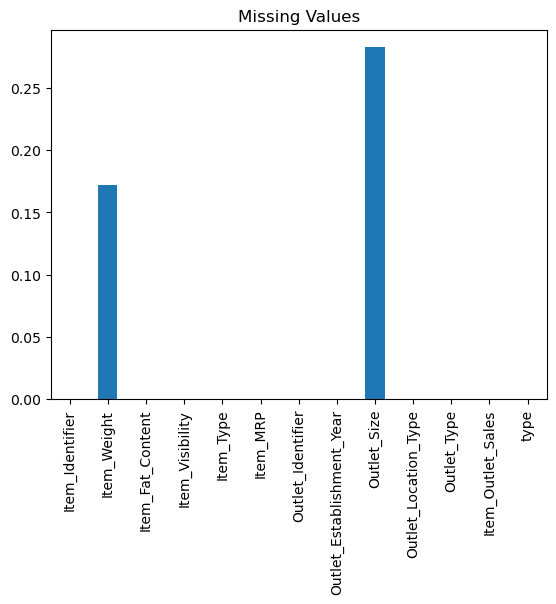

In [703]:
train_df.isna().mean().plot(kind='bar',title="Missing Values")

In [704]:
train_df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
type                            0
dtype: int64

<AxesSubplot:xlabel='Item_Identifier'>

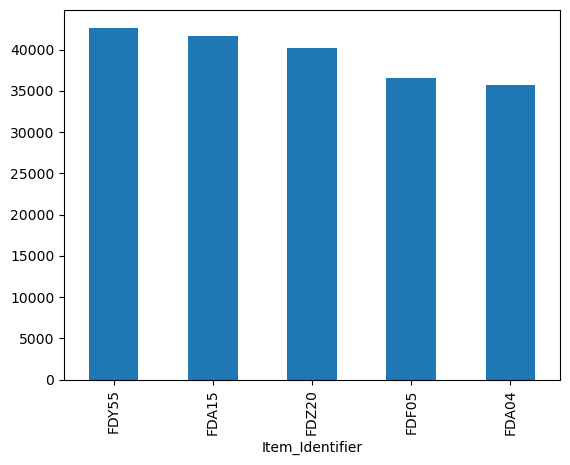

In [705]:
train_df.groupby("Item_Identifier")['Item_Outlet_Sales'].sum().sort_values(ascending=False).head(5).plot(kind='bar')

In [706]:
train_df.select_dtypes(include=['object']).columns.drop('Item_Identifier')

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type', 'type'],
      dtype='object')

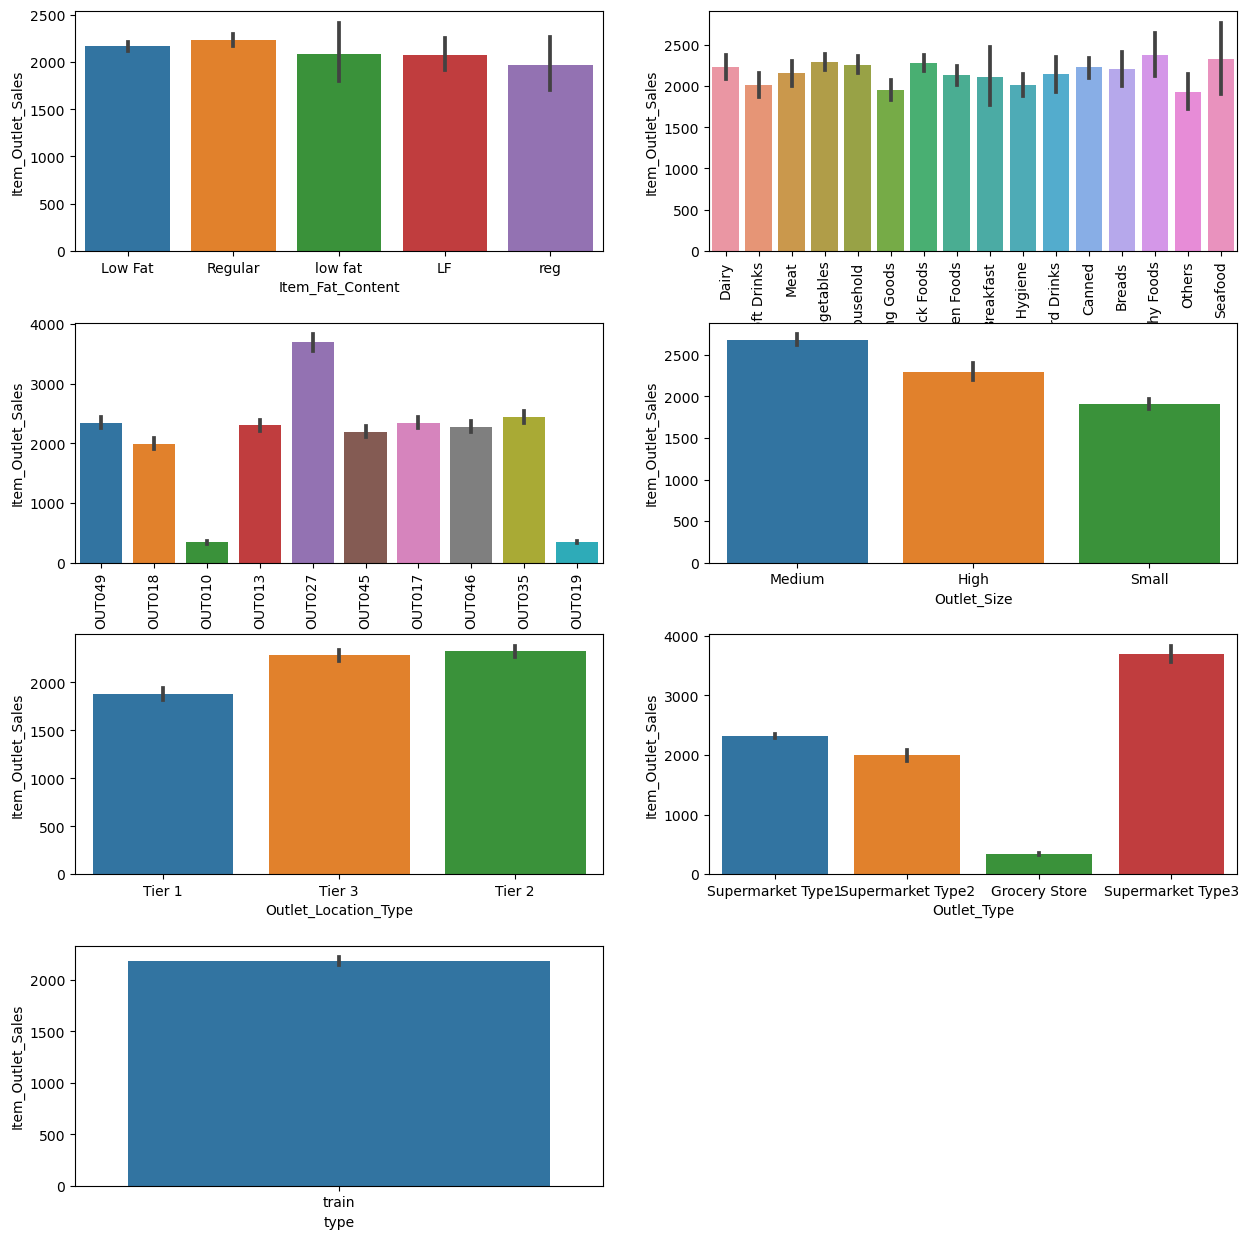

In [707]:
category_cols = train_df.select_dtypes(include=['object']).columns.drop('Item_Identifier')
count=1
plt.subplots(figsize=(15,80))
for column in category_cols:
    plt.subplot(20,2,count)
    plt.subplots_adjust(hspace = 0.3)
    sns.barplot(x=train_df[column], y=train_df["Item_Outlet_Sales"])
    if(train_df[column].nunique() > 7):
        plt.xticks(rotation=90);
    count+=1
plt.show()

<AxesSubplot:>

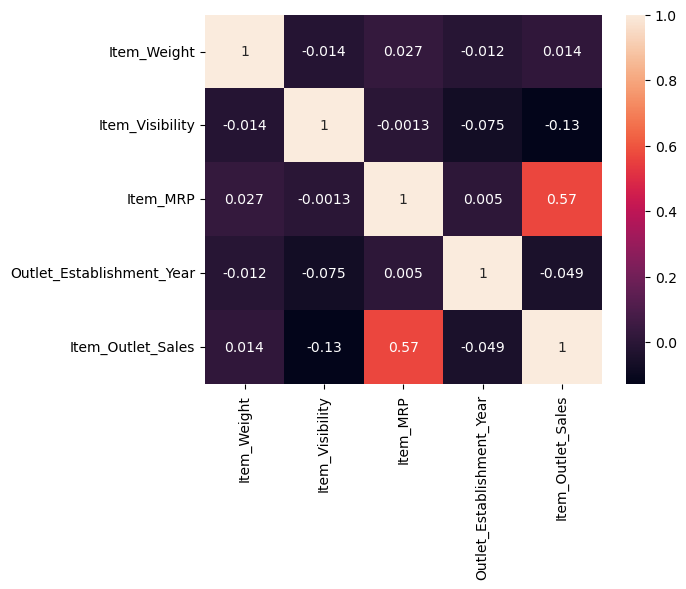

In [708]:
sns.heatmap(train_df.corr(),annot=True)

In [709]:
print(train_df.shape)
for column in data.columns:
    print('*'*len(column),column,'*'*len(column),sep="\n")
    print(train_df[column].value_counts())
    print('Unique values: ', train_df[column].nunique())

(8523, 13)
***************
Item_Identifier
***************
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64
Unique values:  1559
***********
Item_Weight
***********
12.150    86
17.600    82
13.650    77
11.800    76
15.100    68
          ..
7.275      2
7.685      1
9.420      1
6.520      1
5.400      1
Name: Item_Weight, Length: 415, dtype: int64
Unique values:  415
****************
Item_Fat_Content
****************
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
Unique values:  5
***************
Item_Visibility
***************
0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: Item_Visibility, Length: 7880, dtype: int64
Unique values:  7880
*********
Ite

# Preprocessing

Replace 'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'

In [710]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular' })
data['Item_Fat_Content'].value_counts()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64

**"Item_Identifier" - 1st 2 letter maps to item_type**

In [711]:
data[['Item_Type','Item_Identifier']]

,Item_Type,Item_Identifier
0,Dairy,FDA15
1,Soft Drinks,DRC01
2,Meat,FDN15
3,Fruits and Vegetables,FDX07
4,Household,NCD19
...,...,...
14199,Snack Foods,FDB58
14200,Starchy Foods,FDD47
14201,Health and Hygiene,NCO17
14202,Canned,FDJ26


In [712]:
#Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

In [713]:
data.loc[data['Item_Type_Combined'] == 'Non-Consumable', 'Item_Fat_Content'] = "Non-Edible"

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

In [714]:
data['outlet_years'] = 2013 - data['Outlet_Establishment_Year']

In [715]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
type                          object
Item_Type_Combined            object
outlet_years                   int64
dtype: object

In [716]:
data.groupby(["Item_Identifier"]).mean().reset_index()[['Item_Identifier', 'Item_Weight']]

,Item_Identifier,Item_Weight
0,DRA12,11.600
1,DRA24,19.350
2,DRA59,8.270
3,DRB01,7.390
4,DRB13,6.115
...,...,...
1554,NCZ30,6.590
1555,NCZ41,19.850
1556,NCZ42,10.500
1557,NCZ53,9.600


In [717]:
group.loc[group.index == 'DRA12', 'Item_Weight'].values[0]
#.loc[group['Item_Identifier'].isin(num1_range), 'Item_Weight']

11.6

In [718]:
empty_weight = data['Item_Weight'].isna()
avg_weight = data.groupby(["Item_Identifier"]).mean()
data.loc[empty_weight, 'Item_Weight'] = data.loc[empty_weight,"Item_Identifier"].apply(lambda x: avg_weight.loc[group.index == x, 'Item_Weight'].values[0])

In [719]:
data['Item_Weight'].isna().sum()

0

In [720]:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet_Identifier'])

In [721]:
data.dtypes

Item_Identifier                       object
Item_Weight                          float64
Item_Visibility                      float64
Item_Type                             object
Item_MRP                             float64
Outlet_Establishment_Year              int64
Item_Outlet_Sales                    float64
type                                  object
outlet_years                           int64
Item_Fat_Content_Low Fat               uint8
Item_Fat_Content_Non-Edible            uint8
Item_Fat_Content_Regular               uint8
Outlet_Location_Type_Tier 1            uint8
Outlet_Location_Type_Tier 2            uint8
Outlet_Location_Type_Tier 3            uint8
Outlet_Size_High                       uint8
Outlet_Size_Medium                     uint8
Outlet_Size_Small                      uint8
Outlet_Type_Grocery Store              uint8
Outlet_Type_Supermarket Type1          uint8
Outlet_Type_Supermarket Type2          uint8
Outlet_Type_Supermarket Type3          uint8
Item_Type_

In [722]:
data.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,type,outlet_years,Item_Fat_Content_Low Fat,...,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,FDA15,9.30,0.016047,Dairy,249.8092,1999,3735.1380,train,14,1,...,0,0,0,0,0,0,0,0,0,1
1,DRC01,5.92,0.019278,Soft Drinks,48.2692,2009,443.4228,train,4,0,...,0,0,0,1,0,0,0,0,0,0
2,FDN15,17.50,0.016760,Meat,141.6180,1999,2097.2700,train,14,1,...,0,0,0,0,0,0,0,0,0,1
3,FDX07,19.20,0.000000,Fruits and Vegetables,182.0950,1998,732.3800,train,15,0,...,1,0,0,0,0,0,0,0,0,0
4,NCD19,8.93,0.000000,Household,53.8614,1987,994.7052,train,26,0,...,0,1,0,0,0,0,0,0,0,0


In [723]:
#Drop the columns which have been converted to different types:
# Remove Identifiers
data.drop(['Item_Type','Outlet_Establishment_Year', 'Item_Identifier'],axis=1,inplace=True)

In [724]:
data.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,type,outlet_years,Item_Fat_Content_Low Fat,Item_Fat_Content_Non-Edible,Item_Fat_Content_Regular,Outlet_Location_Type_Tier 1,...,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,9.30,0.016047,249.8092,3735.1380,train,14,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,5.92,0.019278,48.2692,443.4228,train,4,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,17.50,0.016760,141.6180,2097.2700,train,14,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,19.20,0.000000,182.0950,732.3800,train,15,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,8.93,0.000000,53.8614,994.7052,train,26,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [725]:
#Divide into test and train:
train = data.loc[data['type']=="train"]
test = data.loc[data['type']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','type'],axis=1,inplace=True)
train.drop(['type'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

C:\Users\vinot\AppData\Local\Temp\ipykernel_17612\3543184335.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['Item_Outlet_Sales','type'],axis=1,inplace=True)
C:\Users\vinot\AppData\Local\Temp\ipykernel_17612\3543184335.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['type'],axis=1,inplace=True)


In [726]:
train.isna().sum()

Item_Weight                          0
Item_Visibility                      0
Item_MRP                             0
Item_Outlet_Sales                    0
outlet_years                         0
Item_Fat_Content_Low Fat             0
Item_Fat_Content_Non-Edible          0
Item_Fat_Content_Regular             0
Outlet_Location_Type_Tier 1          0
Outlet_Location_Type_Tier 2          0
Outlet_Location_Type_Tier 3          0
Outlet_Size_High                     0
Outlet_Size_Medium                   0
Outlet_Size_Small                    0
Outlet_Type_Grocery Store            0
Outlet_Type_Supermarket Type1        0
Outlet_Type_Supermarket Type2        0
Outlet_Type_Supermarket Type3        0
Item_Type_Combined_Drinks            0
Item_Type_Combined_Food              0
Item_Type_Combined_Non-Consumable    0
Outlet_Identifier_OUT010             0
Outlet_Identifier_OUT013             0
Outlet_Identifier_OUT017             0
Outlet_Identifier_OUT018             0
Outlet_Identifier_OUT019 

In [728]:
estimators = [RandomForestRegressor(), AdaBoostRegressor(),  LGBMRegressor()]
features = train.drop('Item_Outlet_Sales', axis=1)
target = train['Item_Outlet_Sales']
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=42)
accuracy = []
for estimator in estimators:
    estimator.fit(X_train, y_train)
    #Predict training set:
    dtrain_predictions = estimator.predict(X_test)

    #Perform cross-validation:
    cv_score = cross_val_score(estimator, features, target, cv=20, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print('******Train********')
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y_test, dtrain_predictions)))
    print("R2 : %.4g" % np.sqrt(metrics.r2_score(y_test, dtrain_predictions)))
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    accuracy.append({'RMSE': np.sqrt(metrics.mean_squared_error(y_test, dtrain_predictions)),
                     'R2': np.sqrt(metrics.r2_score(y_test, dtrain_predictions)),
                      'CV Score': np.mean(cv_score)})
    

******Train********

Model Report
RMSE : 1078
R2 : 0.7566
CV Score : Mean - 1128 | Std - 47.3 | Min - 1043 | Max - 1209
******Train********

Model Report
RMSE : 1104
R2 : 0.7426
CV Score : Mean - 1230 | Std - 72.71 | Min - 1127 | Max - 1387
******Train********

Model Report
RMSE : 1050
R2 : 0.7711
CV Score : Mean - 1105 | Std - 49.57 | Min - 1029 | Max - 1203


In [729]:
accuracy

[{'RMSE': 1077.967906776865,
  'R2': 0.756617213651738,
  'CV Score': 1128.4550432227634},
 {'RMSE': 1104.224411642373,
  'R2': 0.7425556520235218,
  'CV Score': 1230.3058092548636},
 {'RMSE': 1049.6826417528664,
  'R2': 0.7711106009194196,
  'CV Score': 1105.3036044074065}]

In [730]:
estimators[2]

LGBMRegressor()

In [678]:
predicted_value = estimators[2].predict(test)

In [679]:
predicted_value

array([1360.6778907 , 1336.35354909,  681.28580079, ..., 2005.11915148,
       4731.12387575, 1426.15619288])

In [680]:
test_df['Item_Outlet_Sales'] = np.round(predicted_value, decimals=0)

In [681]:
test_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,type,Item_Outlet_Sales
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,test,1361.0
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1,test,1336.0
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store,test,681.0
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1,test,2235.0
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,test,7204.0


In [682]:
test_df[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']].to_csv("submission.csv", index=False)